### list of ft models
- 'ada:ft-personal-2023-03-13-22-18-36'
  - 3 class, initial attempt
- "ada:ft-personal-2023-03-17-16-36-40"
  - also 3 class, but I regarded this one as better
- "ada:ft-personal-2023-03-17-17-21-10"
  - labels with spaces removed
- "ada:ft-personal-2023-03-17-17-49-37"
  - data shuffled now
- "curie:ft-personal-2023-03-17-18-08-07"
  - trained on curie to see of results better
- "ada:ft-personal-2023-03-20-00-09-00"
  - went up to 10 epochs and back to ada

In [10]:
ft_model = "ada:ft-personal-2023-03-20-00-09-00"

In [1]:
import pandas as pd
import openai
import os
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

In [ ]:

api_key = os.getenv("OPENAI_API_KEY")
print(type(api_key))
openai.api_key = api_key

data = pd.read_excel("data.xlsx")

labels = data['student'] 
texts = data['response']

df = pd.DataFrame(zip(texts, labels), columns = ['prompt','completion']) #[:300]
df.head()

df.to_excel("3class.xlsx")

df.to_json("essays.jsonl", orient='records', lines=True)

# !openai tools fine_tunes.prepare_data -f essays.jsonl -q

# !openai api fine_tunes.create -t "essays_prepared_train.jsonl" -v "essays_prepared_valid.jsonl" --compute_classification_metrics --classification_positive_class " 10th grade" -m ada

# !openai api fine_tunes.results -i ft-B29wadYuk9CqMvVvKJKQ4P5u > student_result5.csv

      step  elapsed_tokens  elapsed_examples  training_loss  \
0        1             745                 1       0.046484   
1        2            1586                 2       0.055089   
2        3            2371                 3       0.049060   
3        4            3100                 4       0.046796   
4        5            4053                 5       0.023661   
...    ...             ...               ...            ...   
2396  2397         2022485              2397       0.005302   
2397  2398         2023606              2398       0.007171   
2398  2399         2024615              2399       0.009144   
2399  2400         2025520              2400       0.006525   
2400  2401         2026521              2401       0.008004   

      training_sequence_accuracy  training_token_accuracy  validation_loss  \
0                            0.0                 0.000000         0.048879   
1                            0.0                 0.000000              NaN   
2        

<Axes: >

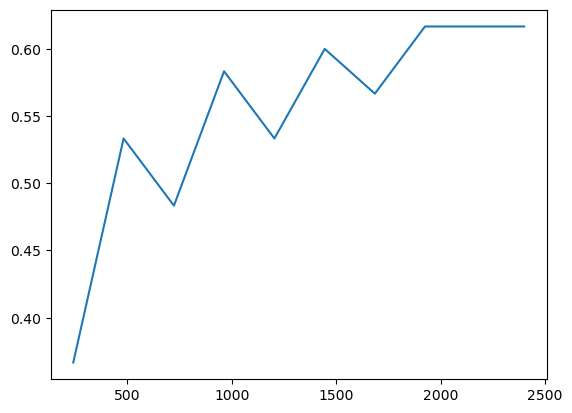

In [6]:
results = pd.read_csv('student_result5.csv')

print(results)

print(results[results['classification/accuracy'].notnull()].tail(1))

results[results['classification/accuracy'].notnull()]['classification/accuracy'].plot()

<Axes: >

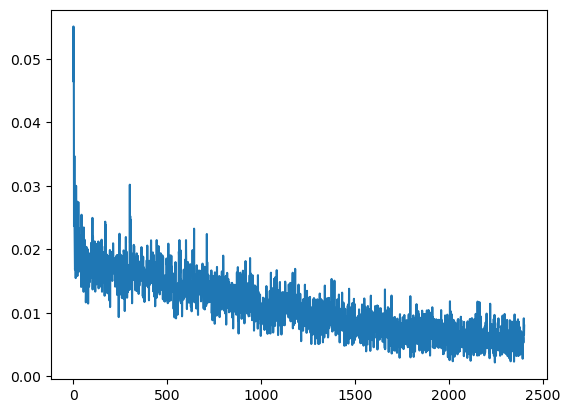

In [7]:
results[results['training_loss'].notnull()]['training_loss'].plot()

In [8]:
test = pd.read_json('students2_prepared_valid.jsonl', lines=True)
test.head()

,prompt,completion
0,\n\nThanksgiving is the day when families get ...,6thgrade
1,\n\nHave you ever heard of early jets? They we...,6thgrade
2,\n\nSilicon Valley is a term used to describe ...,10thgrade
3,\n\nCivic humanism is a philosophy that emphas...,6thgrade
4,\n\nBoomer-Lit And The Silver Economy\n\nBoome...,6thgrade


In [11]:
for i in range(len(test)):
    res = openai.Completion.create(model=ft_model, prompt=test['prompt'][i] + '\n\n###\n\n', max_tokens=1, temperature=0, logprobs=2)
    test.loc[i, 'prediction'] = res['choices'][0]['text']
    #test.loc[i, 'log_probs'] = res['choices'][0]['logprobs']['top_logprobs'][0]

print(test.head(20))

                                               prompt  completion prediction
0   \n\nThanksgiving is the day when families get ...    6thgrade          6
1   \n\nHave you ever heard of early jets? They we...    6thgrade          6
2   \n\nSilicon Valley is a term used to describe ...   10thgrade    college
3   \n\nCivic humanism is a philosophy that emphas...    6thgrade         10
4   \n\nBoomer-Lit And The Silver Economy\n\nBoome...    6thgrade          6
5   \n\nNormandy Seventy Five Years On\n\nThe Norm...    6thgrade          6
6   \n\nDonating to a good cause is a noble act th...   10thgrade          6
7   \n\nIn the Yoruba tribe of West Africa, the bi...     college         10
8   \n\nAs the 2019–2020 NBA season draws to a clo...     college         10
9   \n\nThe USHJA Wheeler Museum is a historically...   10thgrade         10
10  \n\nEvelyn McHale’s Most Beautiful Suicide\n\n...   10thgrade         10
11  \n\nThe end of World War II marked a turning p...     college    college

Predicted   10   6   college
Actual                      
 10         11   2         4
 6           3  17         1
 college    13   1         8


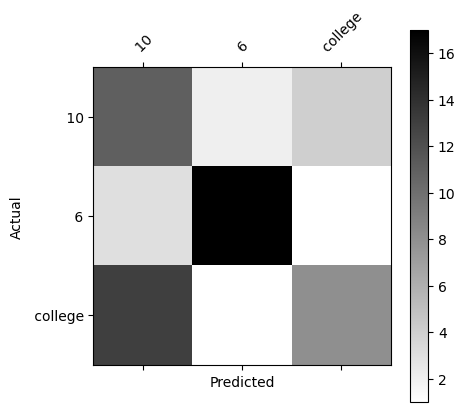

In [24]:
classes = list(test['prediction'].unique())

test['completion'] = test['completion'].str.replace('thgrade', '')

y_actu = pd.Series(test['completion'].values, name='Actual')
y_pred = pd.Series(test['prediction'].values, name='Predicted')

def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.gray_r):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    #plt.tight_layout()
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)


df_confusion = pd.crosstab(y_actu, y_pred)
plot_confusion_matrix(df_confusion)